# Cluster points along a spatial network

Cluster a set of fake firms based on their network distances from each other.

In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.cluster import DBSCAN

ox.config(use_cache=True, log_console=True)

In [2]:
# parameterize DBSCAN
eps = 300 #meters
minpts = 3 #smallest cluster size allowed

# fake data: create n_firms evenly disbursed across n_clusters
#n_firms = 31635
n_firms = 30
n_clusters = 3

place = 'Piedmont, California, USA'

In [3]:
# get the street network
G = ox.graph_from_place(place, network_type='drive')

## Create a fake set of firms

In [4]:
# randomly select n_clusters number of nodes from the graph
np.random.seed(7)
firm_centers = np.random.choice(G.nodes(), size=n_clusters, replace=False)

In [5]:
# scatter some firms around the selected nodes
xs = []
ys = []
for osmid in firm_centers:
    x = G.node[osmid]['x']
    y = G.node[osmid]['y']
    np.random.seed(1)
    xs.extend(np.random.normal(loc=x, scale=0.001, size=int(n_firms/len(firm_centers))))
    ys.extend(np.random.normal(loc=y, scale=0.001, size=int(n_firms/len(firm_centers))))
    
firms = pd.DataFrame({'x':xs, 'y':ys})
len(firms)

30

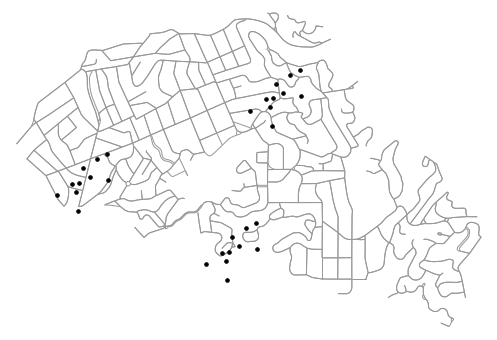

In [6]:
# plot the firms and the points around which they cluster
ns = 0#[100 if n in centers else 0 for n in G.nodes()]
fig, ax = ox.plot_graph(G, node_color='#aaaaaa', node_size=ns, show=False, close=True)
ax.scatter(x=firms['x'], y=firms['y'], c='k', marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

## Regular spatial clustering

In [7]:
%%time
# compute DBSCAN using straight-line haversine distances
eps_rad = eps / 3671000. #meters to radians
db = DBSCAN(eps=eps_rad, min_samples=minpts, metric='haversine', algorithm='ball_tree')
firms['spatial_cluster'] = db.fit_predict(np.deg2rad(firms[['y', 'x']]))

Wall time: 8 ms


In [8]:
len(firms['spatial_cluster'].unique())

3

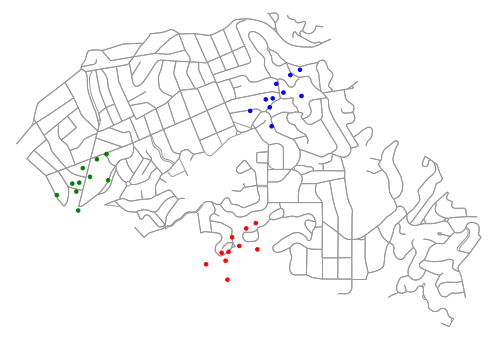

In [9]:
# plot firms by cluster
color_map = {-1:'gray', 0:'g', 1:'r', 2:'b', 3:'m'}
point_colors = [color_map[c] for c in firms['spatial_cluster']]
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=True)
ax.scatter(x=firms['x'], y=firms['y'], c=point_colors, marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

## Attach nearest node to each firm then make network-based distance matrix

Speed up distance matrix computation: rather than calculating every firm to every firm, find every node with at least 1 firm attached, then calculate every such node to every such node distance. Once we have the node-to-node distances, reindex it to make use those distances firm-to-firm.

In [10]:
# attach nearest network node to each firm
firms['nn'] = ox.get_nearest_nodes(G, X=pd.Series(xs), Y=pd.Series(ys), method='balltree')
print(len(firms['nn']))

# we'll get distances for each pair of nodes that have firms attached to them
nodes_unique = pd.Series(firms['nn'].unique())
nodes_unique.index = nodes_unique.values
print(len(nodes_unique))

# convert MultiDiGraph to DiGraph for simpler faster distance matrix computation
G_dm = nx.DiGraph(G)

30
22


In [11]:
# calculate network-based distance between each node
def network_distance_matrix(u, G, vs=nodes_unique):
    
    dists = [nx.dijkstra_path_length(G, source=u, target=v, weight='length') for v in vs]
    return pd.Series(dists, index=vs)

In [12]:
%%time
# create node-based distance matrix called node_dm
node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm)
node_dm = node_dm.astype(int)
print(node_dm.size)

484
Wall time: 162 ms


## Make distance matrix sparse

In a regular distance matrix, zero elements are considered neighbors (they're on top of each other). With a sparse matrix only nonzero elements may be considered neighbors for DBSCAN. First, make all zeros a very small number instead, so we don't ignore them. Otherwise, we wouldn't consider two firms attached to the same node as cluster neighbors. Then set everything bigger than epsilon to 0, so we do ignore it as we won't consider them neighbors anyway.

In [13]:
node_dm[node_dm == 0] = 1
node_dm[node_dm > eps] = 0

In [14]:
# reindex node-based distance matrix to create network-based distance matrix called ndm
ndm = node_dm.reindex(index=firms['nn'], columns=firms['nn'])
print('{:,.0f}'.format(ndm.size))

900


In [15]:
%%time
# convert network-based distance matrix to a sparse matrix
ndm_sparse = csr_matrix(ndm)

Wall time: 0 ns


In [16]:
# how much space does the dense matrix use, in MB?
dense_size = ndm.as_matrix().nbytes / 1e6
dense_size

0.0036

In [17]:
# how much space does the sparse matrix use, in MB?
sparse_size = (ndm_sparse.data.nbytes + ndm_sparse.indptr.nbytes + ndm_sparse.indices.nbytes) / 1e6
sparse_size

0.001628

## Cluster firms along the network

Use the sparse network-based distance matrix to compute DBSCAN (converges much faster and uses much less memory than using the dense matrix with a big data set).

In [18]:
%%time
# use metric=precomputed to fit model to the sparse network-based distance matrix
db = DBSCAN(eps=eps, min_samples=minpts, metric='precomputed')
firms['network_cluster'] = db.fit_predict(ndm_sparse)

Wall time: 4 ms


In [19]:
len(firms['network_cluster'].unique())

4

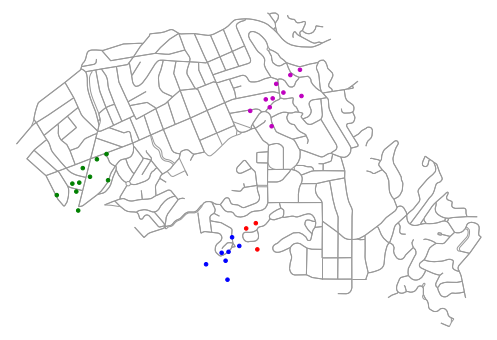

In [20]:
# plot firms by cluster
color_map = {-1:'gray', 0:'g', 1:'r', 2:'b', 3:'m', 4:'y', 5:'k', 6:'orange', 7:'pink'}
point_colors = [color_map[c] for c in firms['network_cluster']]
ns = [50 if n in firms['nn'].values else 0 for n in G.nodes()]
fig, ax = ox.plot_graph(G, node_color='gray', node_size=0, show=False, close=True)
ax.scatter(x=firms['x'], y=firms['y'], c=point_colors, marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

In [21]:
# save the graph to disk
ox.save_graph_shapefile(G, folder='data')

In [22]:
# save and show the clustered firms data set
firms = firms.reindex(columns=['x', 'y', 'nn', 'spatial_cluster', 'network_cluster'])
firms.to_csv('data/clustered.csv', encoding='utf-8', index=False)
firms[10:15]

,x,y,nn,spatial_cluster,network_cluster
10,-122.230444,37.818733,53156417,1,1
11,-122.232680,37.815210,53068829,1,2
12,-122.232596,37.816948,260707479,1,2
13,-122.233141,37.816886,53068829,1,2
14,-122.231203,37.818404,53156417,1,1


### Future work: phase two

Explode firms -> jobs. So mom and pop store would be represented by say 2 or 3 points at that firm's lat-long. Facebook would be represented by 1000 points at its lat-long. Then set a high-ish min_pts (say 20) and eps= 300m (for instance) to ignore small firms and capture jobs agglomerations and big solo firms.